# Lasso et ElasticNet Regression


### Steps:
* 1- Procedure 
    * 1.1 - Importation de package
    * 1.2 - Obeservation des variable
    * 1.3 - Les valeur manquent
    * 1.4 - Ajout des variable et enleve les valeur aberent
    * 1.5 - Transformation
    * 1.6 - Prepare for model
* 2- Model (lassoCV er ElasticNetCV..)
* 3- Prepare le fiche de submission 


### 1.1-  Importation de package


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LassoCV ,ElasticNetCV,RidgeCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor


In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
test2=pd.read_csv("test.csv")
len_train=train.shape[0]
houses=pd.concat([train,test], sort=False)
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


### 1.2- Obeservation des variable (quantitative ,qualitative )


In [3]:
houses.select_dtypes(include='object').head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [4]:
houses.select_dtypes(include=['float','int']).head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000.0


#### When we read the data description file we realize that "", a numerical features (not ordinal), should be transformed into categorical. I'll do this later in this kernel.

### 1.3 - Les valeur Manquent

### Categorical


In [5]:
houses.select_dtypes(include='object').isnull().sum()[houses.select_dtypes(include='object').isnull().sum()>0]

MSZoning           4
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

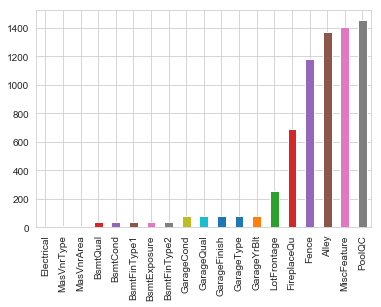

In [6]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Les caleur manquent dans c'est variable peux avoir le sens de NONE 

In [7]:
train["PoolQC"] = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train["Fence"] = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train['MSSubClass'] = train['MSSubClass'].fillna("None")
train["Functional"] = train["Functional"].fillna("Typ")
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

In [8]:
test["PoolQC"] = test["PoolQC"].fillna("None")
test["MiscFeature"] = test["MiscFeature"].fillna("None")
test["Alley"] = test["Alley"].fillna("None")
test["Fence"] = test["Fence"].fillna("None")
test["FireplaceQu"] = test["FireplaceQu"].fillna("None")
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test[col] = test[col].fillna('None')
test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["Functional"] = test["Functional"].fillna("Typ")
test['MSSubClass'] = test['MSSubClass'].fillna("None")
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])
test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['Utilities'] = test['Utilities'].fillna(test['MSZoning'].mode()[0])

### Numeric

In [9]:
houses.select_dtypes(include=['int','float']).isnull().sum()[houses.select_dtypes(include=['int','float']).isnull().sum()>0]

LotFrontage      486
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

Some NAs means "None" (which I will fill with 0) or means "Not Available" (which I will fill with mean)

In [10]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)


In [11]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

In [12]:
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


### 1.4 - Ajout des variable et enleve les valeur aberent

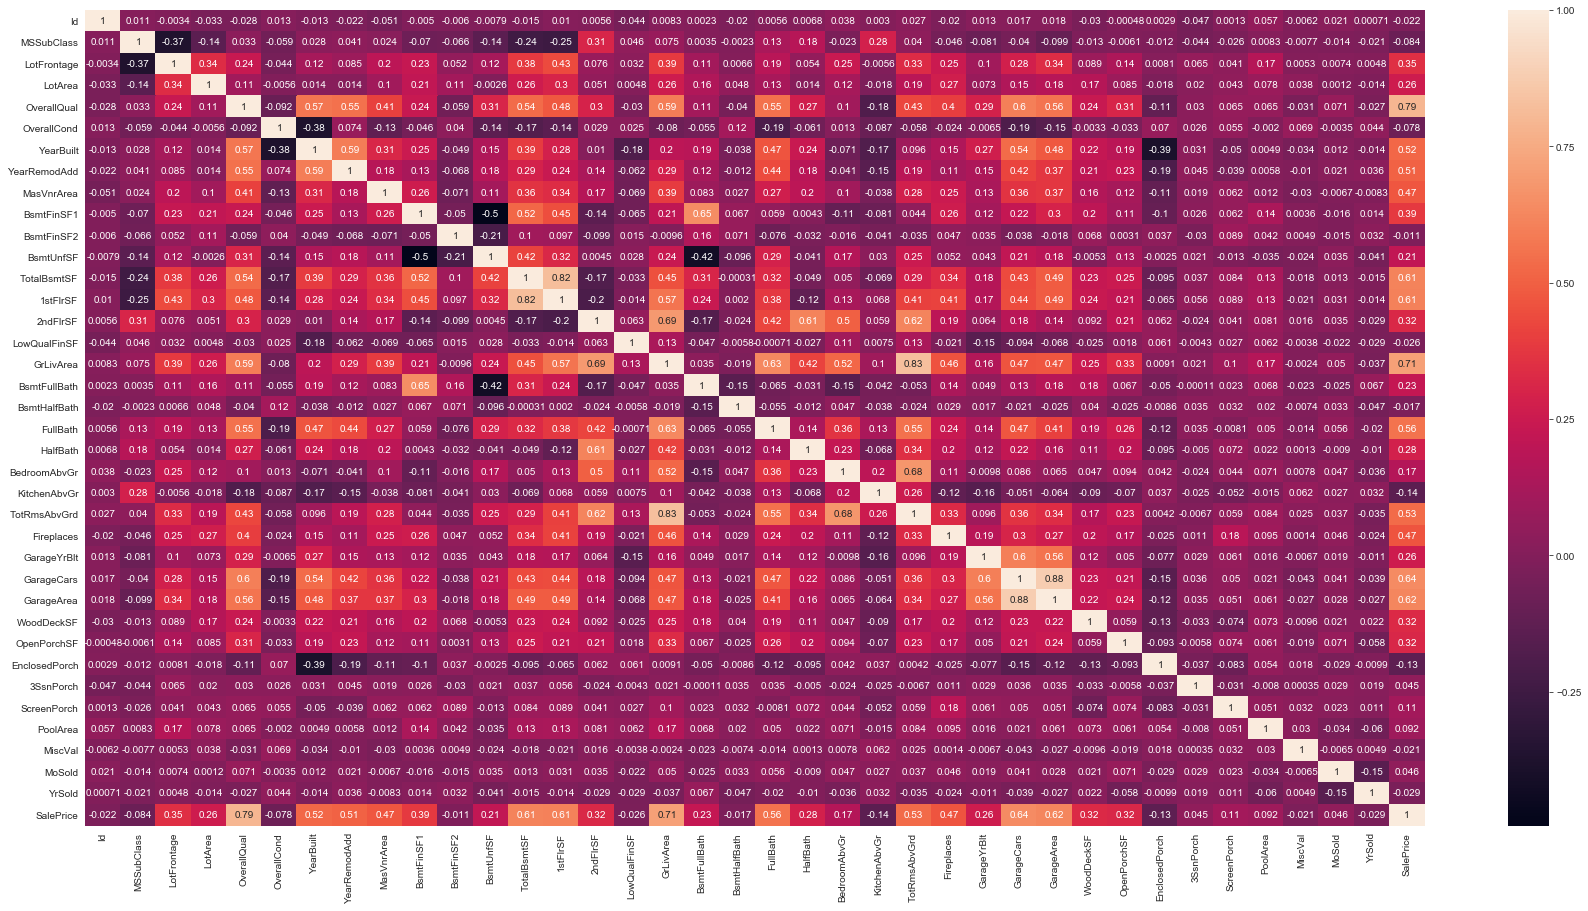

In [13]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr(), annot=True)

In [14]:
#removing outliers recomended by author
train = train[train['GrLivArea']<4000]

In [15]:
len_train=train.shape[0]
print(train.shape)

(1456, 81)


In [16]:
houses=pd.concat([train,test], sort=False)
houses['_OverallQualCond'] = houses['OverallQual'] + (houses['OverallCond'] - 5) * 0.5
houses['_TotalSF'] = houses['TotalBsmtSF'] + houses['GrLivArea']
houses['_PorchArea'] = houses['OpenPorchSF'] + houses['EnclosedPorch'] + houses['3SsnPorch'] + houses['ScreenPorch']
houses['_TotalArea'] = houses['_TotalSF'] + houses['GarageArea'] + houses['_PorchArea']
houses['_Rooms'] = houses['TotRmsAbvGrd'] + houses['FullBath'] + houses['HalfBath']
houses['_BathRooms'] = houses['FullBath'] + houses['BsmtFullBath'] + (houses['HalfBath'] + houses['BsmtHalfBath']) * 0.7
houses['_GrLAreaAveByRms'] = houses['GrLivArea'] / houses['_Rooms']

houses['YrBltAndRemod']=houses['YearBuilt']+houses['YearRemodAdd']
houses['TotalSF']=houses['TotalBsmtSF'] + houses['1stFlrSF'] + houses['2ndFlrSF']

houses['Total_sqr_footage'] = (houses['BsmtFinSF1'] + houses['BsmtFinSF2'] +
                                 houses['1stFlrSF'] + houses['2ndFlrSF'])

houses['Total_Bathrooms'] = (houses['FullBath'] + (0.5 * houses['HalfBath']) +
                               houses['BsmtFullBath'] + (0.5 * houses['BsmtHalfBath']))

houses['Total_porch_sf'] = (houses['OpenPorchSF'] + houses['3SsnPorch'] +
                              houses['EnclosedPorch'] + houses['ScreenPorch'] +
                              houses['WoodDeckSF'])


In [17]:

houses['haspool'] = houses['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
houses['has2ndfloor'] = houses['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
houses['hasgarage'] = houses['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
houses['hasbsmt'] = houses['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
houses['hasfireplace'] = houses['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### 1.5 - Transformations

Numerical to categorical

In [18]:
#MSSubClass=The building class
houses['MSSubClass'] = houses['MSSubClass'].apply(str)
#Year and month sold are transformed into categorical features.
houses['YrSold'] = houses['YrSold'].astype(str)
houses['MoSold'] = houses['MoSold'].astype(str)

Skew

In [19]:
skew=houses.select_dtypes(include=['int','float']).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew_df=pd.DataFrame({'Skew':skew})
skewed_df=skew_df[(skew_df['Skew']>0.5)|(skew_df['Skew']<-0.5)]

In [20]:
skewed_df.index

Index(['MiscVal', 'PoolArea', 'haspool', 'LotArea', 'LowQualFinSF',
       '3SsnPorch', 'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch',
       'ScreenPorch', 'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF',
       '_PorchArea', 'WoodDeckSF', 'SalePrice', 'Total_porch_sf', '1stFlrSF',
       'Total_sqr_footage', 'LotFrontage', 'GrLivArea', 'BsmtFinSF1',
       '_TotalSF', 'TotalSF', 'BsmtUnfSF', '_GrLAreaAveByRms', '_TotalArea',
       '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'TotalBsmtSF',
       'BsmtFullBath', '_Rooms', 'OverallCond', 'YearBuilt', 'GarageYrBlt',
       'hasgarage', 'hasbsmt'],
      dtype='object')

In [21]:
train=houses[:len_train]
test=houses[len_train:]

In [22]:
lam=0.1
for col in ('MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF',
       'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF', 'Fireplaces',
       'HalfBath', 'TotalBsmtSF', 'BsmtFullBath', 'OverallCond', 'YearBuilt',
       'GarageYrBlt'):
    train[col]=boxcox1p(train[col],lam)
    test[col]=boxcox1p(test[col],lam)

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [23]:
train['SalePrice']=np.log1p(train['SalePrice'])

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Categorical to one hot encoding

In [24]:
houses=pd.concat([train,test], sort=False)
houses=pd.get_dummies(houses)

### 1.6 - Prepare for model


In [25]:
train=houses[:len_train]
test=houses[len_train:]

In [26]:
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [27]:
x=train.drop('SalePrice', axis=1)
y=train['SalePrice']
test=test.drop('SalePrice', axis=1)

In [28]:
sc=RobustScaler()
x=sc.fit_transform(x)
test=sc.transform(test)

# 2 - Model

In [29]:
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

#model=Lasso(alpha =0.001, random_state=1)

modelLA=LassoCV(alphas=alphas2, random_state=42)
modelEL=ElasticNetCV(alphas=alphas2,random_state=42)
modelRI=RidgeCV(alphas=alphas2)



In [30]:
g_boost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, 
                                   loss='huber', random_state =5)
gb_model = g_boost.fit(x, y)

In [31]:
stack_gen = StackingCVRegressor(regressors=(modelRI,modelLA,modelEL,g_boost),
                                meta_regressor=g_boost,
                                use_features_in_secondary=True)


In [32]:
modelEL.fit(x,y)
modelLA.fit(x,y)
modelRI.fit(x,y)

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did 

RidgeCV(alphas=array([5.e-05, 1.e-04, 2.e-04, 3.e-04, 4.e-04, 5.e-04, 6.e-04, 7.e-04,
       8.e-04]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [33]:
stack_gen_model = stack_gen.fit(np.array(x), np.array(y))

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value 

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective di

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective di

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did 

# 3- Submission

In [34]:
def blend(x):
    return(modelEL.predict(x)+modelLA.predict(x)+modelRI.predict(x)+gb_model.predict(x))/4
pred=stack_gen_model.predict(np.array(test))
preds=np.exp(pred)

In [35]:
output=pd.DataFrame({'Id':test2.Id, 'SalePrice':preds})
output.to_csv('TEST2.csv', index=False)

In [36]:
output

,Id,SalePrice
0,1461,121297.689914
1,1462,155545.053615
2,1463,182508.469688
3,1464,201642.688354
4,1465,194894.025649
5,1466,171964.400285
6,1467,179685.389321
7,1468,163453.611363
8,1469,196171.708948
9,1470,118109.292393


In [37]:
# Save the predictions in form of a dataframe
submission = pd.DataFrame()
submission['Id'] = test2.Id
submission['SalePrice'] = preds

top_public = pd.read_csv('TEST1.csv')

final_blend = (0.4*top_public.SalePrice.values + 0.6*preds)

blended_submission = pd.DataFrame()

blended_submission['Id'] = test2.Id
blended_submission['SalePrice'] = final_blend

blended_submission.to_csv('blended_submission2.csv', index=False)